In [1]:
import torch.nn as nn
import torchvision
from torchvision import transforms
import torch
from matplotlib import pyplot as plt
import numpy as np
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader

In [2]:
batch_size = 100
n_classes = 100
n_epochs = 100

In [3]:
# Source: "https://github.com/bentrevett/pytorch-image-classification/blob/master/5_resnet.ipynb"
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()

        block, n_blocks, channels = config
        self.in_channels = channels[0]

        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)

    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):

        layers = []
        
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False

        layers.append(block(self.in_channels, channels, stride, downsample))

        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels

        return nn.Sequential(*layers)

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x, h

class BasicBlock(nn.Module):
    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
                        
        x += i
        x = self.relu(x)
        
        return x

In [4]:
from collections import namedtuple
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

In [5]:
resnet18_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [2,2,2,2],
                               channels = [64, 128, 256, 512])

In [6]:
class Bottleneck(nn.Module):
    
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
    
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                               stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
            
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
                
        if self.downsample is not None:
            i = self.downsample(i)
            
        x += i
        x = self.relu(x)
        return x

In [7]:
resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])


In [8]:


def resnet( pretrained=False,output_dim=n_classes):
    model = ResNet(resnet50_config,output_dim)
    model = model.cuda()

    if(pretrained):
      rmd = models.resnet50(True)
      rmd.fc = nn.Linear(in_features=rmd.fc.in_features, out_features=output_dim, bias=True)
      model.load_state_dict(rmd.state_dict())
    return model

In [9]:
image_transforms = {
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),

    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

In [10]:
dataset = {
    'train': datasets.CIFAR100(
      root="data",
      #train=True,
      download=True,
      transform=image_transforms['train'],
    ),
    'test': datasets.CIFAR100(
      root="data",
      train=False,
      download=True,
      transform=image_transforms['test'],
    )
}

# Dataloader iterators, make sure to shuffle
dataloaders = {
    'train': DataLoader(dataset['train'], batch_size=batch_size,pin_memory=True, shuffle=True),
    'test': DataLoader(dataset['test'], batch_size=batch_size, shuffle=True)
}

Files already downloaded and verified
Files already downloaded and verified


In [11]:
model = resnet(True)

In [43]:
for name, param in model.named_parameters():
    param.requires_grad = True


In [12]:
for name, param in model.named_parameters():
    if param.requires_grad:
        if name == "layer2.2.conv1.weight":
          print("hit")
          break
        param.requires_grad = False


hit


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.001)

In [51]:
losses = []
accuracies = []
r_a = []
r_l = []
model.train()
for epoch in range(n_epochs):
  it = 0
  for data, targets in dataloaders['train']:
    data = data.cuda()
    targets = targets.cuda()
    # Generate predictions
    
    out = model(data)[0]
    # Calculate loss
    
    loss = criterion(out, targets)

    loss.backward()

    accr = (torch.argmax(out,axis=1) == targets).detach().sum().item() / batch_size
    accuracies.append(accr)
    losses.append( loss.item() )
    # Backpropagation
    # Update model parameters
    optimizer.step()
    if it % 20 == 19:
      r_a.append(sum(accuracies[-20:]) / 20)
      r_l.append(sum(losses[-20:]) / 20)
      print(epoch,it,r_a[-1],r_l[-1])
    it += 1
  


0 19 0.012500000000000002 4.636507654190064
0 39 0.04300000000000001 4.501106142997742
0 59 0.084 4.201875483989715
0 79 0.18350000000000002 3.702353537082672
0 99 0.29150000000000004 3.0746110320091247
0 119 0.37 2.4913693189620973
0 139 0.40099999999999997 2.1654837667942046
0 159 0.43050000000000005 2.028397172689438
0 179 0.4685 1.9537582337856292
0 199 0.4924999999999999 1.8836251199245453
0 219 0.4765 1.9509626507759095
0 239 0.45499999999999996 2.12023589015007
0 259 0.4740000000000001 2.06063494682312
0 279 0.4285 2.23843834400177
0 299 0.4405 2.1484829127788543
0 319 0.41850000000000004 2.2578144550323485
0 339 0.41050000000000003 2.2850689053535462
0 359 0.404 2.2803791582584383
0 379 0.40599999999999997 2.324513155221939
0 399 0.4085 2.359835797548294
0 419 0.39449999999999996 2.277678745985031
0 439 0.391 2.406343674659729
0 459 0.392 2.4155311465263365
0 479 0.3695 2.42508385181427
0 499 0.38 2.4015726804733277
1 19 0.391 2.317367321252823
1 39 0.38049999999999995 2.335355

KeyboardInterrupt: ignored

In [58]:
def moving_average(x, w):
    return (np.convolve(x, np.ones(w), 'valid') / w)[::w]

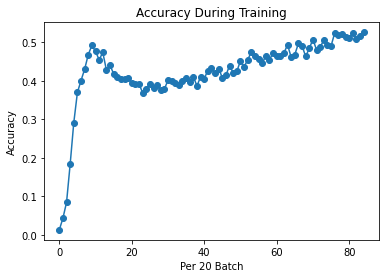

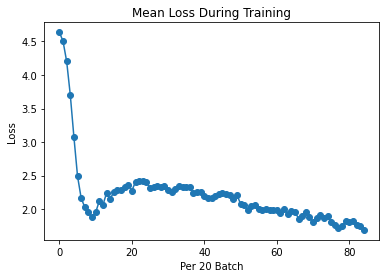

In [61]:
plt.title('Accuracy During Training')
plt.ylabel('Accuracy')
plt.xlabel('Per 20 Batch')
plt.plot(r_a,marker='o')
plt.show()
plt.title('Mean Loss During Training')
plt.ylabel('Loss')
plt.xlabel('Per 20 Batch')
plt.plot(r_l,marker='o')

In [90]:
model.eval()

cnt = 0
c_accr = 0

for data, targets in dataloaders['test']:
    # Generate predictions
    data = data.cuda()
    target= targets.cuda()
    out = model(data)[0]
    accr = (torch.argmax(out,axis=1) == targets).sum().item() / batch_size
    c_accr += (accr)
    cnt+=1

c_accr /= cnt

print(c_accr)

0.48


In [65]:
from google.colab import files,drive
drive.mount('/content/drive')

Mounted at /content/drive


In [72]:
torch.save(model.state_dict(),open("./drive/MyDrive/NN/ResNet.pt","wb"))

In [73]:
!ls ./drive/MyDrive/NN/

AlexNet.pt  ResNet.pt  tf_learning.pt  VGGNet.pt
